In [1]:
# Please visit:
#
# https://download.nkg-mn.com/credo/anomalies/
#
# Pretrained dots_100000.h5 and others can be downloaded from mentioned website.

In [2]:
from align_images_pca import align_image
from PIL import Image
import numpy as np
import glob


DOTS_SRC = 'hit-images-final2/dot'
TRACKS_SRC = 'hit-images-final2/line'
WORMS_SRC = 'hit-images-final2/worms'


def load_images(src):
    images = []
    files = list(glob.glob("%s/*.png" % src))
    files = sorted(files)
    for image_path in files:
        img = Image.open(image_path)
        img = img.convert('L')
        image = np.asarray(img)
        #image = np.asarray(Image.open(image_path).convert('L'))
        image = align_image(image)
        mask = np.where(image > 25, 1, 0)
        image = mask * image
        image = image.astype(np.float32) / np.max(image)
        image = np.expand_dims(image, 2)
        images.append(image)
    return np.asarray(images), files


dots_set, dots_files = load_images(DOTS_SRC)
tracks_set, tacks_files = load_images(TRACKS_SRC)
worms_set, worms_files = load_images(WORMS_SRC)

tracks_set = np.vstack([tracks_set, dots_set])
tacks_files = np.hstack([tacks_files, dots_files])

In [3]:
def augmentation_mirror(src, files):
    images = []
    files_aug = []
    for i in range(0, len(src)):
        img = src[i]
        images.append(img)
        images.append(np.flip(img))
        files_aug.append(files[i])
        files_aug.append(files[i])
    return np.asarray(images), files_aug


tracks2_set, tacks2_files = augmentation_mirror(tracks_set, tacks_files)
worms2_set, worms2_files = augmentation_mirror(worms_set, worms_files)

In [4]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    p = np.random.permutation(df.shape[0])
    n = int(train_percent * len(p))
    m = int(validate_percent * len(p)) + n
    train = p[:n]
    validation = p[n:m]
    test = p[m:]
    return train, validation, test


tracks2_train, tracks2_validate, tracks2_test = train_validate_test_split(tracks2_set)
worms2_train, worms2_validate, worms2_test = train_validate_test_split(worms2_set)

320
0
128
18496
0
256
0
230416
244800
0
36928
0
256
18464
0
128
289
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 60, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 30, 30, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 15, 15, 64)        0 

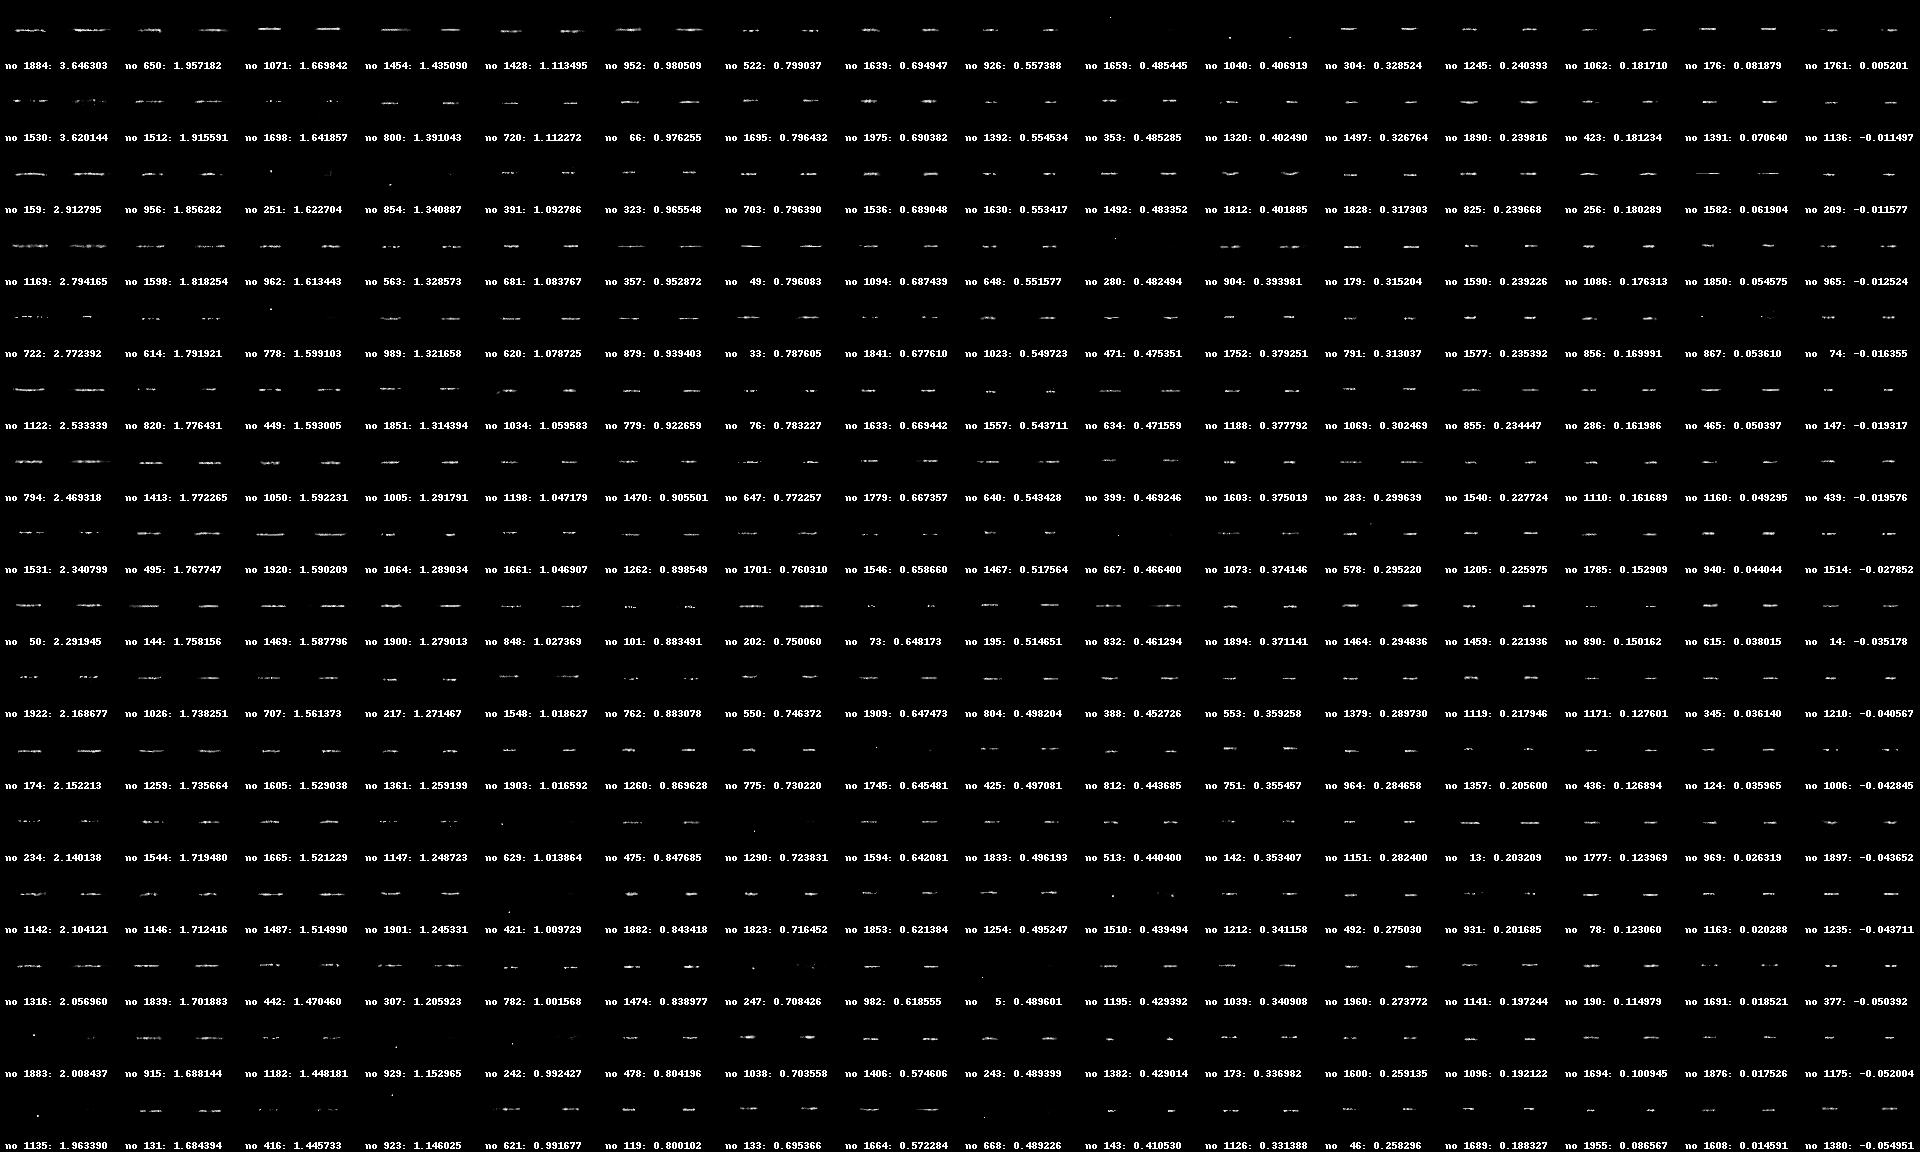

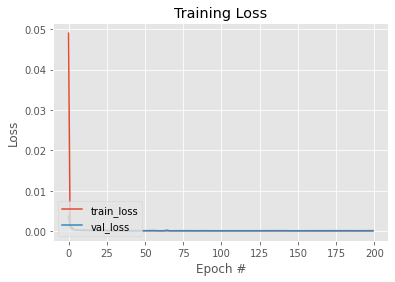

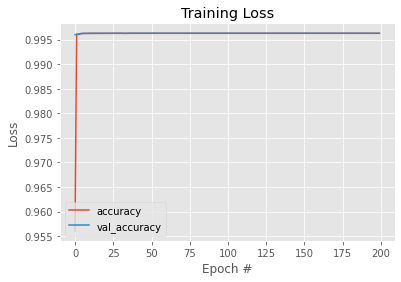

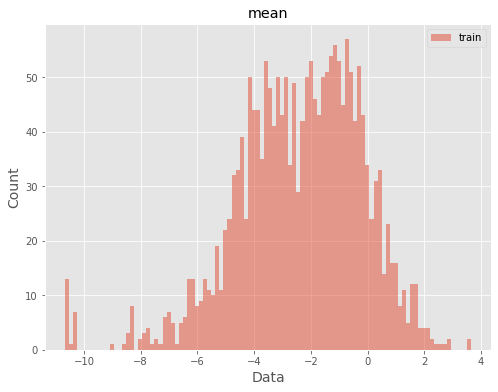

In [5]:
from commons import *
from dataset_loader import load_from_file
from IPython.display import display
import matplotlib.pyplot as plt
import cv2

#DOTS_DST = 'cache/dots_100000.pickle'
#ARTIFACTS_DST = 'cache/artifacts_100000.pickle'

#DOTS_AC = 'cache/dots_100000.h5'
TRACKS_AC = 'cache/th_dots_optics_100000.h5'
#WORMS_AC = 'cache/worms_100000.h5'
#ARTIFACTS_AC = 'cache/artifacts_100000.h5'

def train_and_test(train_set, validation_set, fn):
    autoencoder = original_autoencoder()
    autoencoder = train_or_cache(train_set, autoencoder, fn, validation_set=validation_set, force_train=True)

    for df_func, df_name in zip(
            [dm_func_mean],
            ['mean']
    ):
        for img_set, set_names in zip([validation_set], ['train']):
            decoded = autoencoder.predict(img_set)

            vis, errors = visualize_predictions(decoded, img_set, df_func, False, 16)
            img_path = fn.replace('.h5', '-vis.png')
            hist_path = fn.replace('.h5', '-hist.png')
            cv2.imwrite(img_path, vis)
            display(Image.open(img_path))
            if len(img_set) > 256:
                vis, errors = visualize_predictions(decoded, img_set, df_func, False)
                img_path = fn.replace('.h5', '-vis_full.png')
                cv2.imwrite(img_path, vis)

            plt.figure(figsize=(8,6))
            plt.hist(errors, bins=100, alpha=0.5, label=set_names)
            plt.xlabel("Data", size=14)
            plt.ylabel("Count", size=14)
            plt.title(df_name)
            plt.legend(loc='upper right')
            plt.savefig(hist_path)


train_and_test(tracks2_set[tracks2_train], tracks2_set[tracks2_validate], TRACKS_AC)

In [6]:
from keras.models import load_model

def encoder_embedding(model_file, test_set):
    encoder = load_model(model_file.replace('.h5', '-encoder.h5'))
    embedding = encoder.predict(test_set)
    #with_c = np.vstack([v, np.ones(v.shape) * c])
    #transposed = with_c.transpose()
    return embedding

In [7]:
def dbscan(embedding, t_files, eps):
    img_count = len(embedding)
    threshold = 1
    p = 16

    #for a in range(emb_array.shape[0]):
    #    emb_array[a] = emb_array[a] / w

    #emb_array_copy = np.copy(emb_array[0:img_count, 3:50])
    emb_array_copy = np.copy(embedding[0:img_count, 0:p])


    from sklearn.cluster import DBSCAN
    from sklearn import metrics
    from sklearn.datasets import make_blobs
    from sklearn.preprocessing import StandardScaler

    db = DBSCAN(min_samples=5, eps=eps).fit(emb_array_copy)
    #core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    #core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    import matplotlib.pyplot as plt

    # Black removed and is used for noise instead.
    """
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = labels == k

        xy = emb_array_copy[class_member_mask & core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=14,
        )

        xy = emb_array_copy[class_member_mask & ~core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )
    """
    result = np.where(labels == -1)
    my_ids = result[0]
    print(labels)
    print(my_ids)
    print(len(my_ids))


    import matplotlib.pyplot as plt


    fig = plt.figure(figsize=(32, 32))
    columns = 5
    rows = int(len(my_ids) / 5) + 1

    for aaa in range(len(my_ids)):
        #img_help = cv2.imread('d:\\dane\\credo\\png\\' + all_files_names[my_ids[aaa]])
        img_help = cv2.imread(t_files[my_ids[aaa]])
        print(t_files[my_ids[aaa]])

        aaa1 = aaa + 1
        xxxxx = (aaa % 5) + 1
        r = fig.add_subplot(rows, columns, aaa1)
        r.axis("off")
        plt.imshow(img_help)
        #cv2.imshow(str(aaa), img_help)
        #print(all_files_names[my_ids[0]])

    plt.show()


[0 0 0 ... 0 0 0]
[  11   16   29   31   41   45   85   88  125  172  180  204  207  231
  249  258  271  300  313  340  376  384  426  444  481  520  525  530
  560  568  570  592  604  616  634  651  665  678  683  711  735  744
  749  750  752  774  779  809  818  824  839  854  855  865  883  908
  913  945  955  959  960  973  990  997  998 1001 1066 1071 1088 1091
 1115 1133 1171 1177 1220 1239 1258 1316 1376 1414 1422 1457 1458 1466
 1482 1499 1518 1561 1573 1575 1595 1600 1606 1622 1631 1633 1669 1673
 1679 1689 1705 1709 1763 1795 1809 1841 1849 1870 1904 1917 1938]
111
hit-images-final2/line\24069117.png
hit-images-final2/line\11834173.png
hit-images-final2/dot\11861177.png
hit-images-final2/line\22941583.png
hit-images-final2/line\23424513.png
hit-images-final2/line\16093060.png
hit-images-final2/line\13608594.png
hit-images-final2/line\21977546.png
hit-images-final2/line\23227699.png
hit-images-final2/line\16073561.png
hit-images-final2/line\23761910.png
hit-images-final2/l

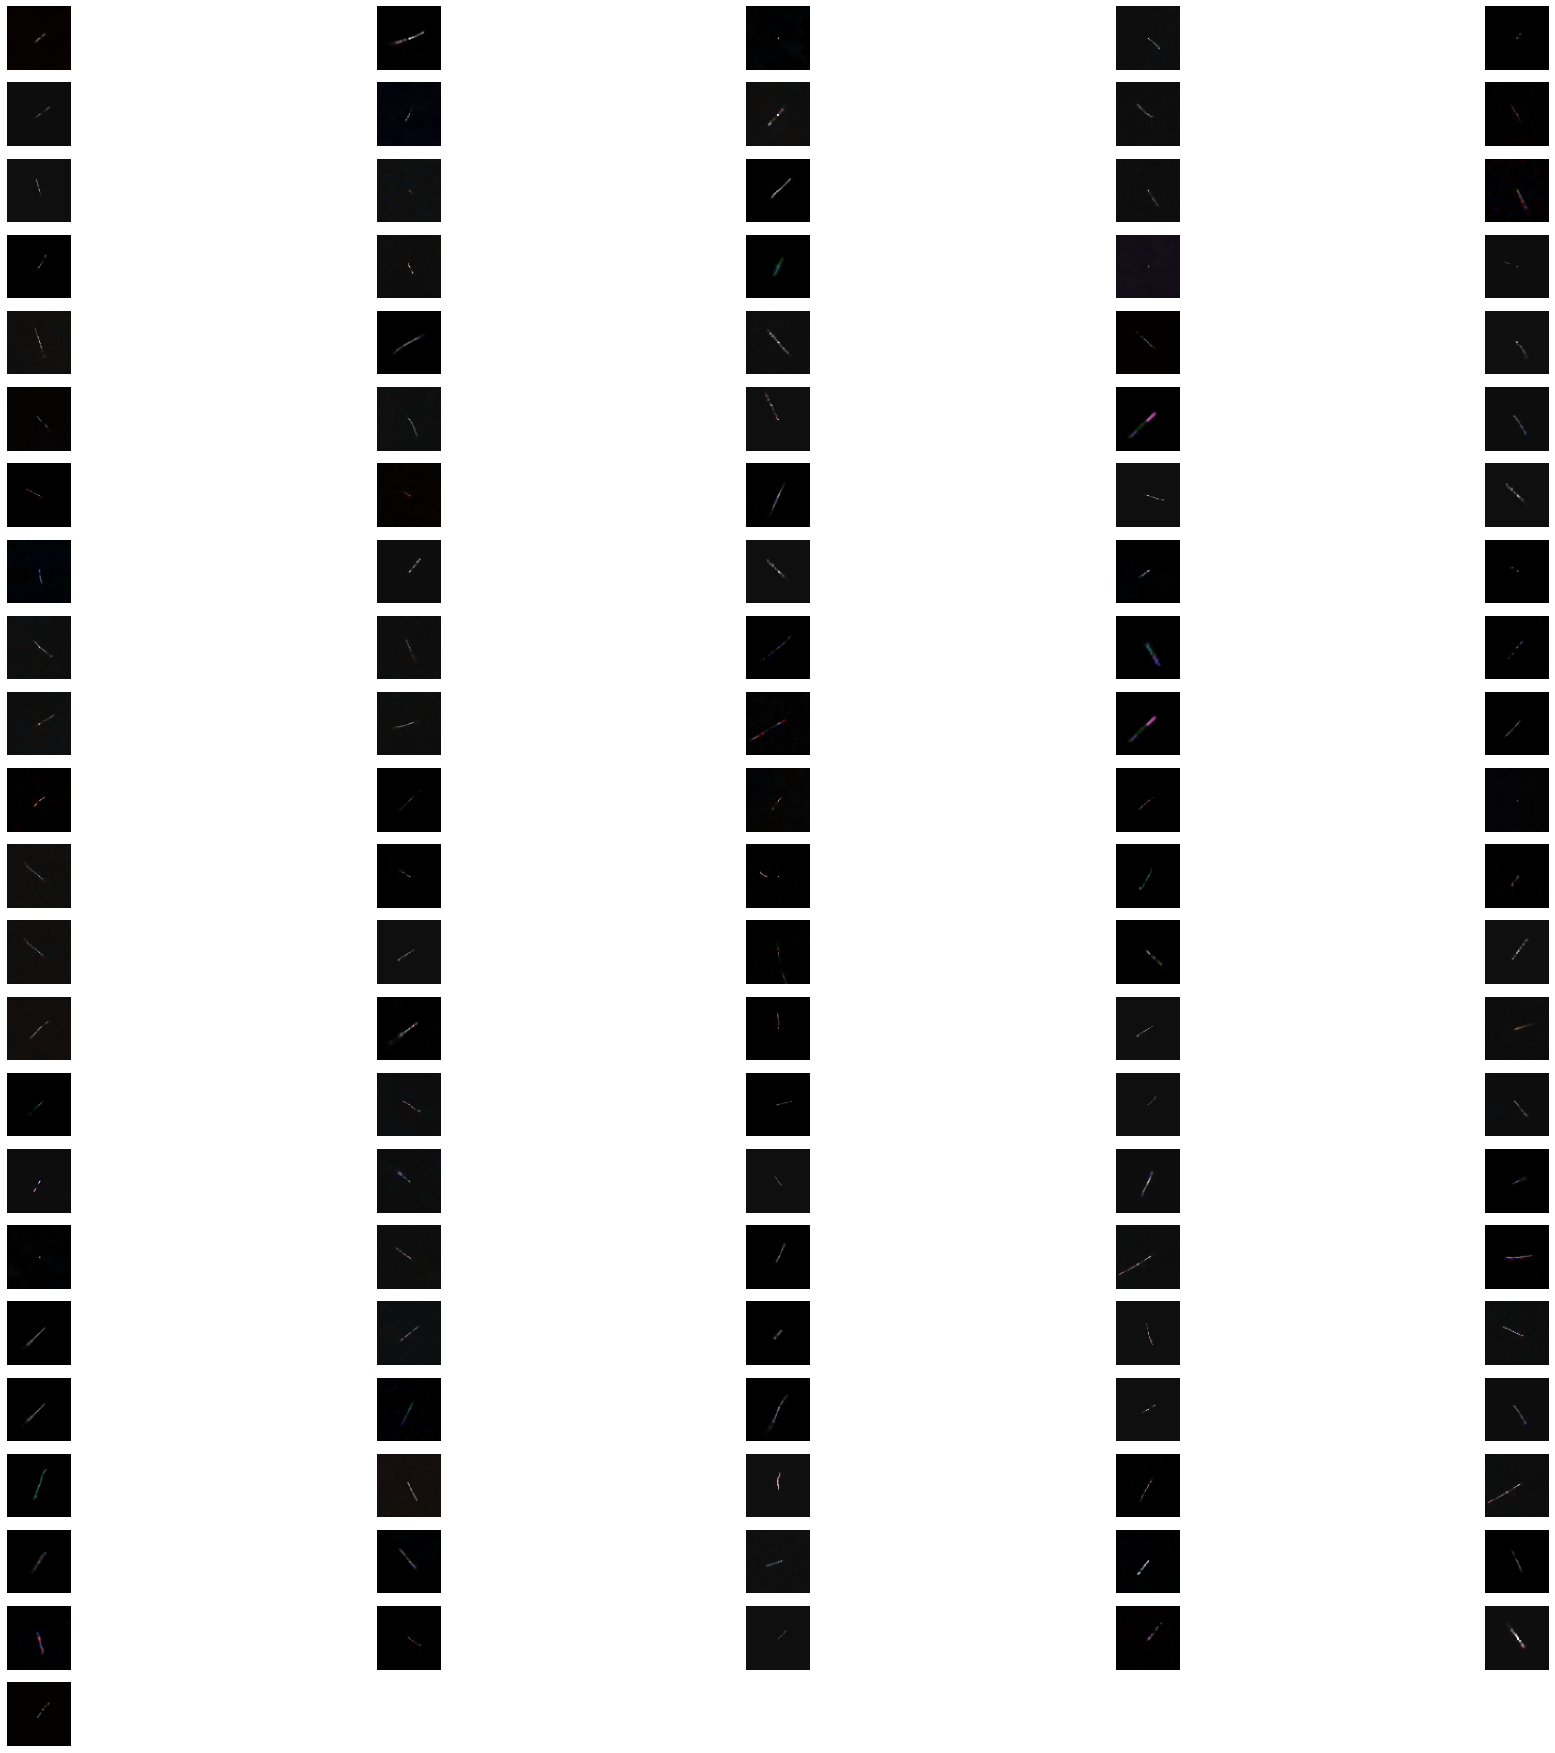

In [8]:
tracks_embedding = encoder_embedding(TRACKS_AC, tracks2_set[tracks2_test])
tracks_t_files = np.asarray(tacks2_files)[tracks2_test]
dbscan(tracks_embedding, tracks_t_files, 120)

[ 0  0  0 ... -1  0 -1]
[  11   16  180  207  300  313  384  426  530  560  568  735  749  750
  752  809  818  824  854  855  913  945  955  959  997 1001 1071 1091
 1133 1220 1258 1499 1518 1595 1631 1633 1795 1809 1938 1978 1979 1980
 1983 1986 1988 1991 1993 1996 2000 2004 2005 2007 2010 2015 2017 2018
 2019 2023 2024 2025 2026 2027 2029 2031 2035 2040 2043 2044 2045 2046
 2048 2049 2051 2055 2056 2057 2058 2059 2062 2063 2067 2069 2072 2074
 2075 2078 2081 2084 2085 2086 2087 2088 2089 2096 2100 2101 2102 2108
 2110 2111 2112 2115 2116 2117 2118 2119 2120 2121 2122 2124 2127 2128
 2131 2132 2134 2137 2140 2146 2152 2165 2167 2169 2172 2174]
124
hit-images-final2/line\24069117.png
hit-images-final2/line\11834173.png
hit-images-final2/line\23761910.png
hit-images-final2/line\17223488.png
hit-images-final2/line\21973157.png
hit-images-final2/dot\13606497.png
hit-images-final2/line\23740643.png
hit-images-final2/line\23767772.png
hit-images-final2/line\22362280.png
hit-images-final2/l

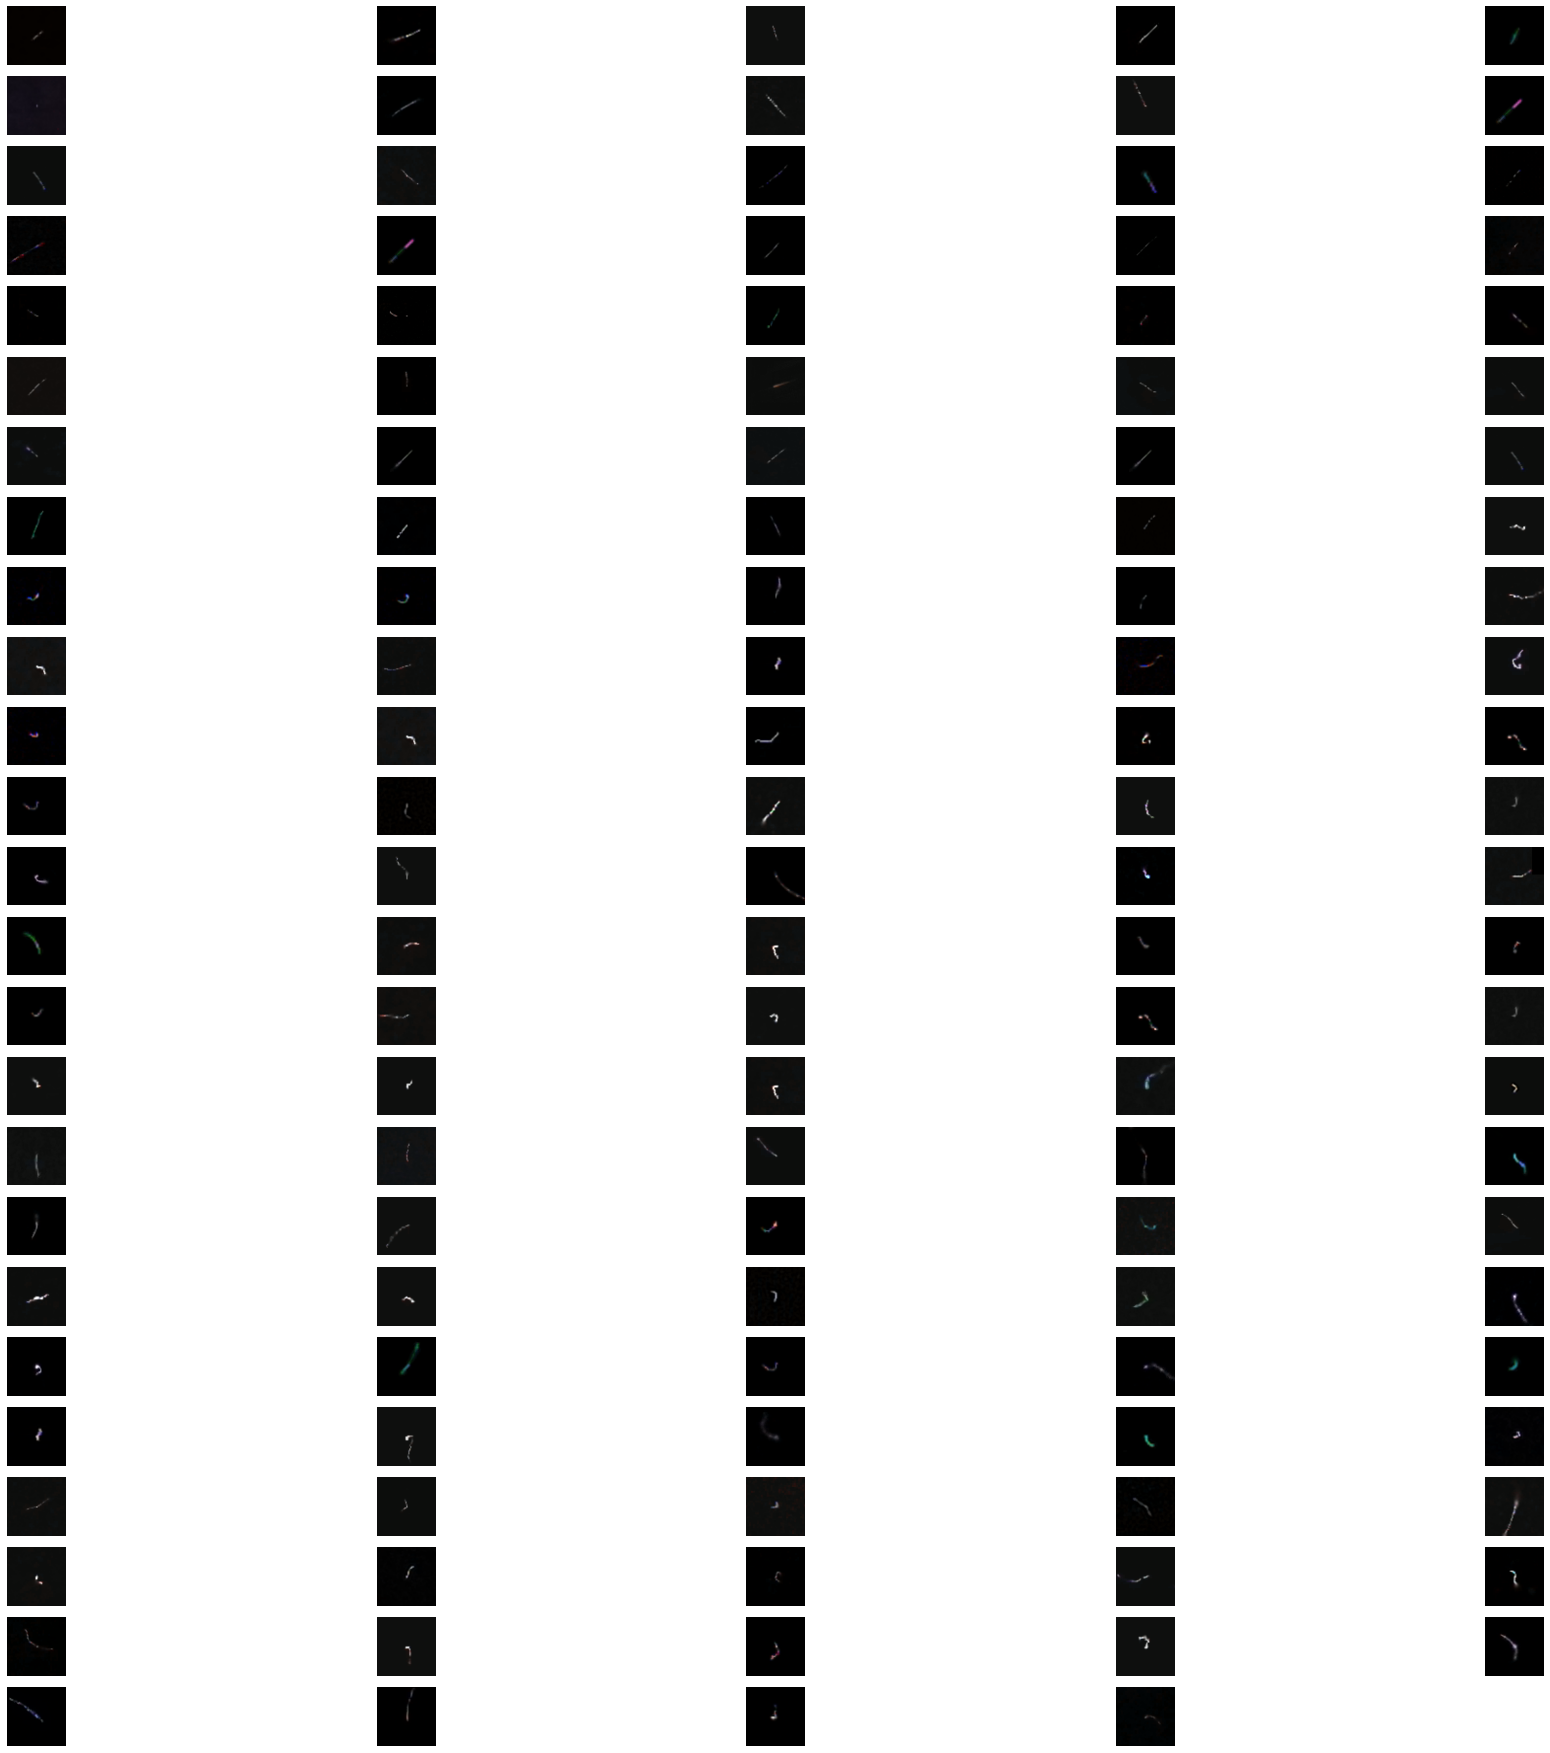

In [9]:
worms_embedding = encoder_embedding(TRACKS_AC, worms2_set[worms2_test])
worms_t_files = np.asarray(worms2_files)[worms2_test]

embedding = np.vstack([tracks_embedding, worms_embedding])
t_files = np.hstack([tracks_t_files, worms_t_files])

dbscan(embedding, t_files, 140)

[ 0  0  0 ...  0  0 -1]
[  16  207  384  560  568  735  749  750  809  818  854  855  913  945
 1071 1258 1518 1633 1938 1976]
20
hit-images-final2/line\11834173.png
hit-images-final2/line\17223488.png
hit-images-final2/line\23740643.png
hit-images-final2/line\22237251.png
hit-images-final2/line\23048228.png
hit-images-final2/line\22448493.png
hit-images-final2/line\23321006.png
hit-images-final2/line\22490031.png
hit-images-final2/line\23143320.png
hit-images-final2/line\22237251.png
hit-images-final2/line\11854900.png
hit-images-final2/line\23186082.png
hit-images-final2/line\23653785.png
hit-images-final2/line\23447798.png
hit-images-final2/line\22032561.png
hit-images-final2/line\23143241.png
hit-images-final2/line\17886508.png
hit-images-final2/line\14276151.png
hit-images-final2/line\23278286.png
hit-images-final2/me\6044.png


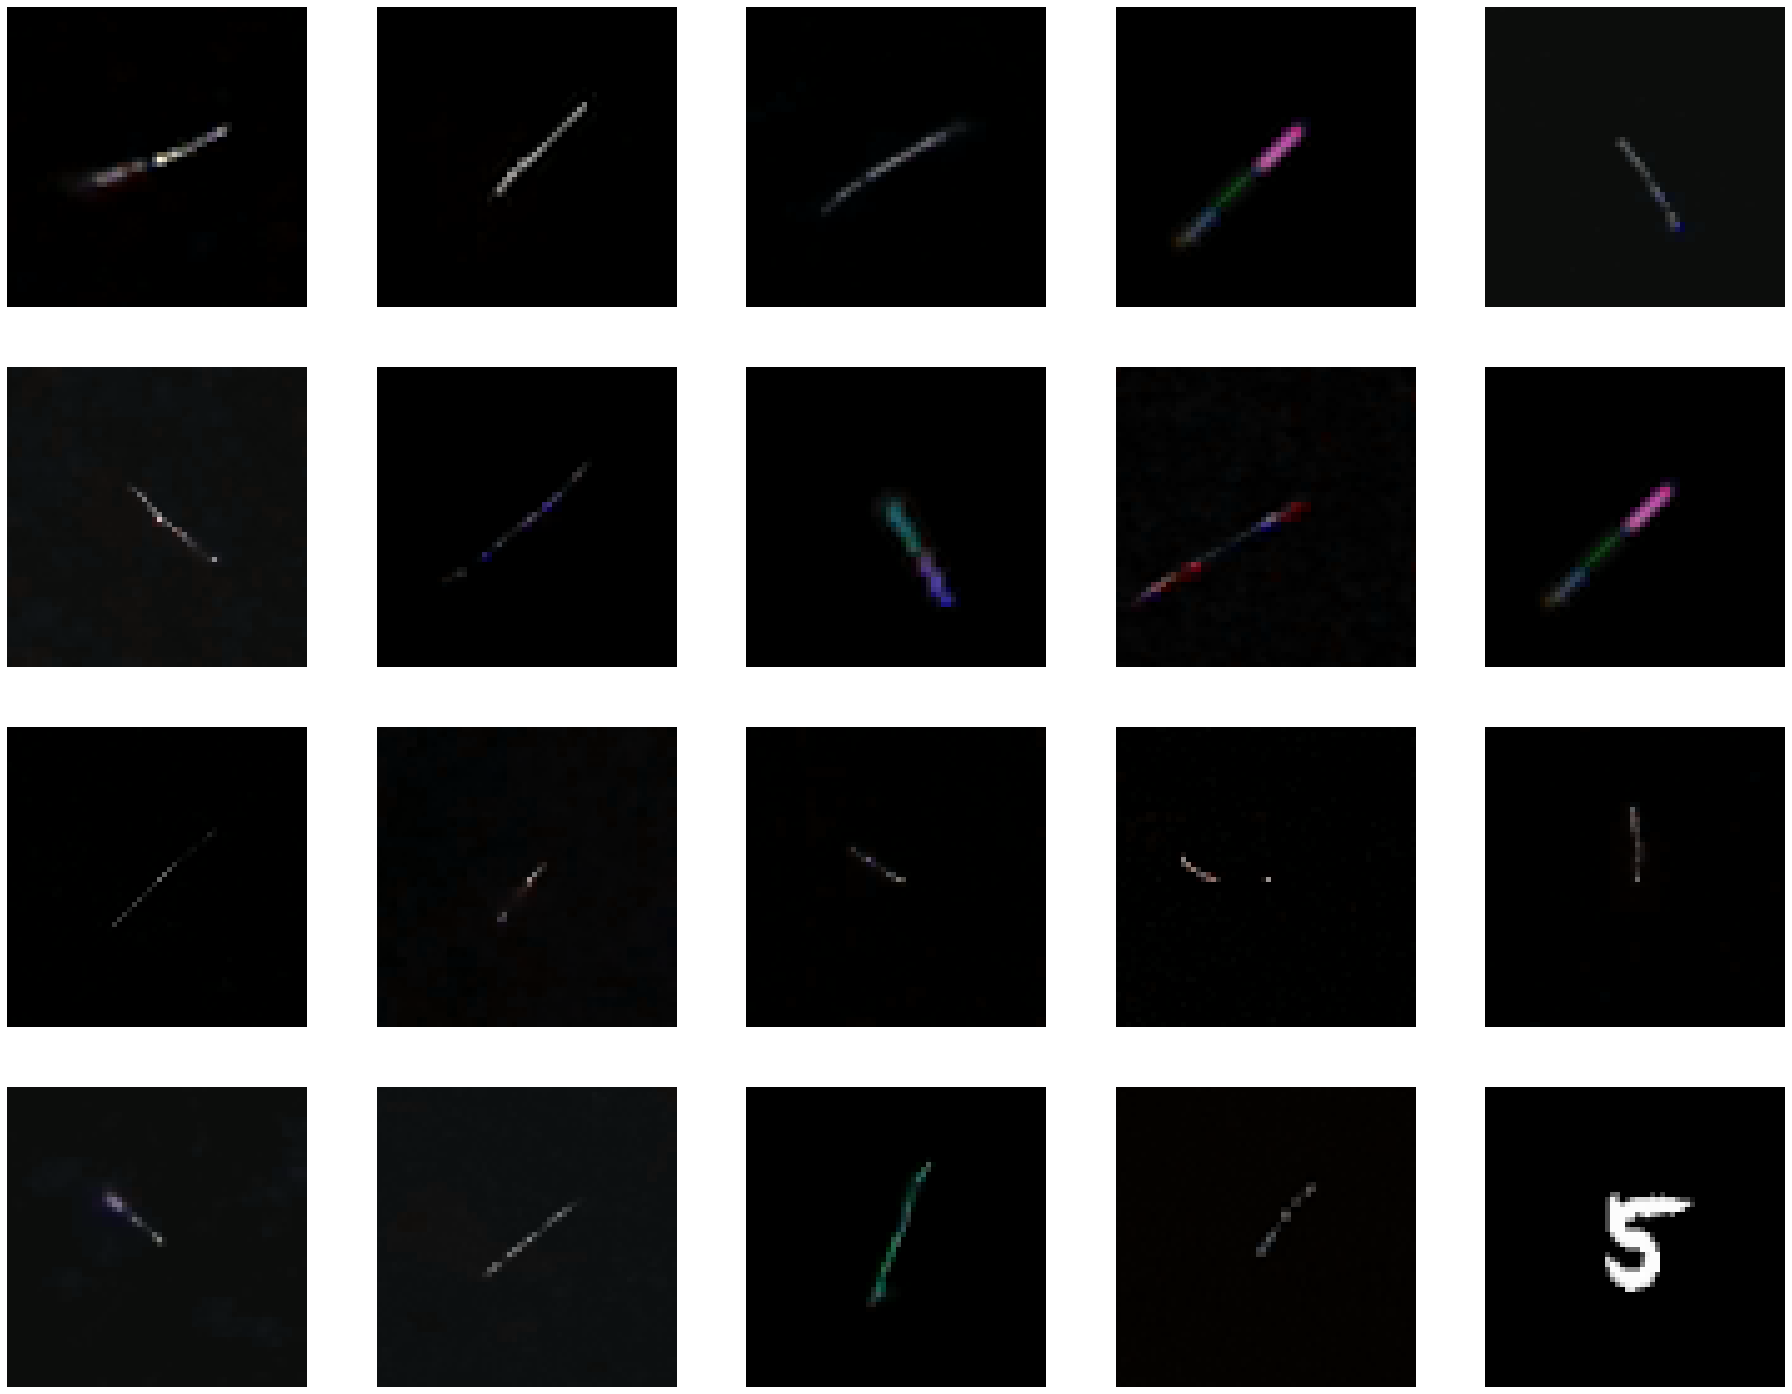

In [10]:
me_set, me_files = load_images('hit-images-final2/me')
me_embedding = encoder_embedding(TRACKS_AC, me_set)
me_files = np.asarray(me_files)

embedding = np.vstack([tracks_embedding, me_embedding])
t_files = np.hstack([tracks_t_files, me_files])

dbscan(embedding, t_files, 150)

In [11]:
def optics(embedding, t_files, eps):
    img_count = len(embedding)
    threshold = 1
    p = 16

    #for a in range(emb_array.shape[0]):
    #    emb_array[a] = emb_array[a] / w

    #emb_array_copy = np.copy(emb_array[0:img_count, 3:50])
    emb_array_copy = np.copy(embedding[0:img_count, 0:p])


    from sklearn.cluster import OPTICS
    from sklearn import metrics
    from sklearn.datasets import make_blobs
    from sklearn.preprocessing import StandardScaler

    db = OPTICS(min_samples=5, cluster_method='dbscan', eps=eps).fit(emb_array_copy)
    #core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    #core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    import matplotlib.pyplot as plt

    # Black removed and is used for noise instead.
    """
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = labels == k

        xy = emb_array_copy[class_member_mask & core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=14,
        )

        xy = emb_array_copy[class_member_mask & ~core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )
    """
    result = np.where(labels == -1)
    my_ids = result[0]
    print(labels)
    print(my_ids)
    print(len(my_ids))


    import matplotlib.pyplot as plt


    fig = plt.figure(figsize=(32, 32))
    columns = 5
    rows = int(len(my_ids) / 5) + 1

    for aaa in range(len(my_ids)):
        #img_help = cv2.imread('d:\\dane\\credo\\png\\' + all_files_names[my_ids[aaa]])
        img_help = cv2.imread(t_files[my_ids[aaa]])
        print(t_files[my_ids[aaa]])

        aaa1 = aaa + 1
        xxxxx = (aaa % 5) + 1
        r = fig.add_subplot(rows, columns, aaa1)
        r.axis("off")
        plt.imshow(img_help)
        #cv2.imshow(str(aaa), img_help)
        #print(all_files_names[my_ids[0]])

    plt.show()

[0 0 0 ... 0 0 0]
[  16  207  384  560  568  735  749  750  809  818  854  855  913  945
 1071 1258 1518 1633 1938]
19
hit-images-final2/line\11834173.png
hit-images-final2/line\17223488.png
hit-images-final2/line\23740643.png
hit-images-final2/line\22237251.png
hit-images-final2/line\23048228.png
hit-images-final2/line\22448493.png
hit-images-final2/line\23321006.png
hit-images-final2/line\22490031.png
hit-images-final2/line\23143320.png
hit-images-final2/line\22237251.png
hit-images-final2/line\11854900.png
hit-images-final2/line\23186082.png
hit-images-final2/line\23653785.png
hit-images-final2/line\23447798.png
hit-images-final2/line\22032561.png
hit-images-final2/line\23143241.png
hit-images-final2/line\17886508.png
hit-images-final2/line\14276151.png
hit-images-final2/line\23278286.png


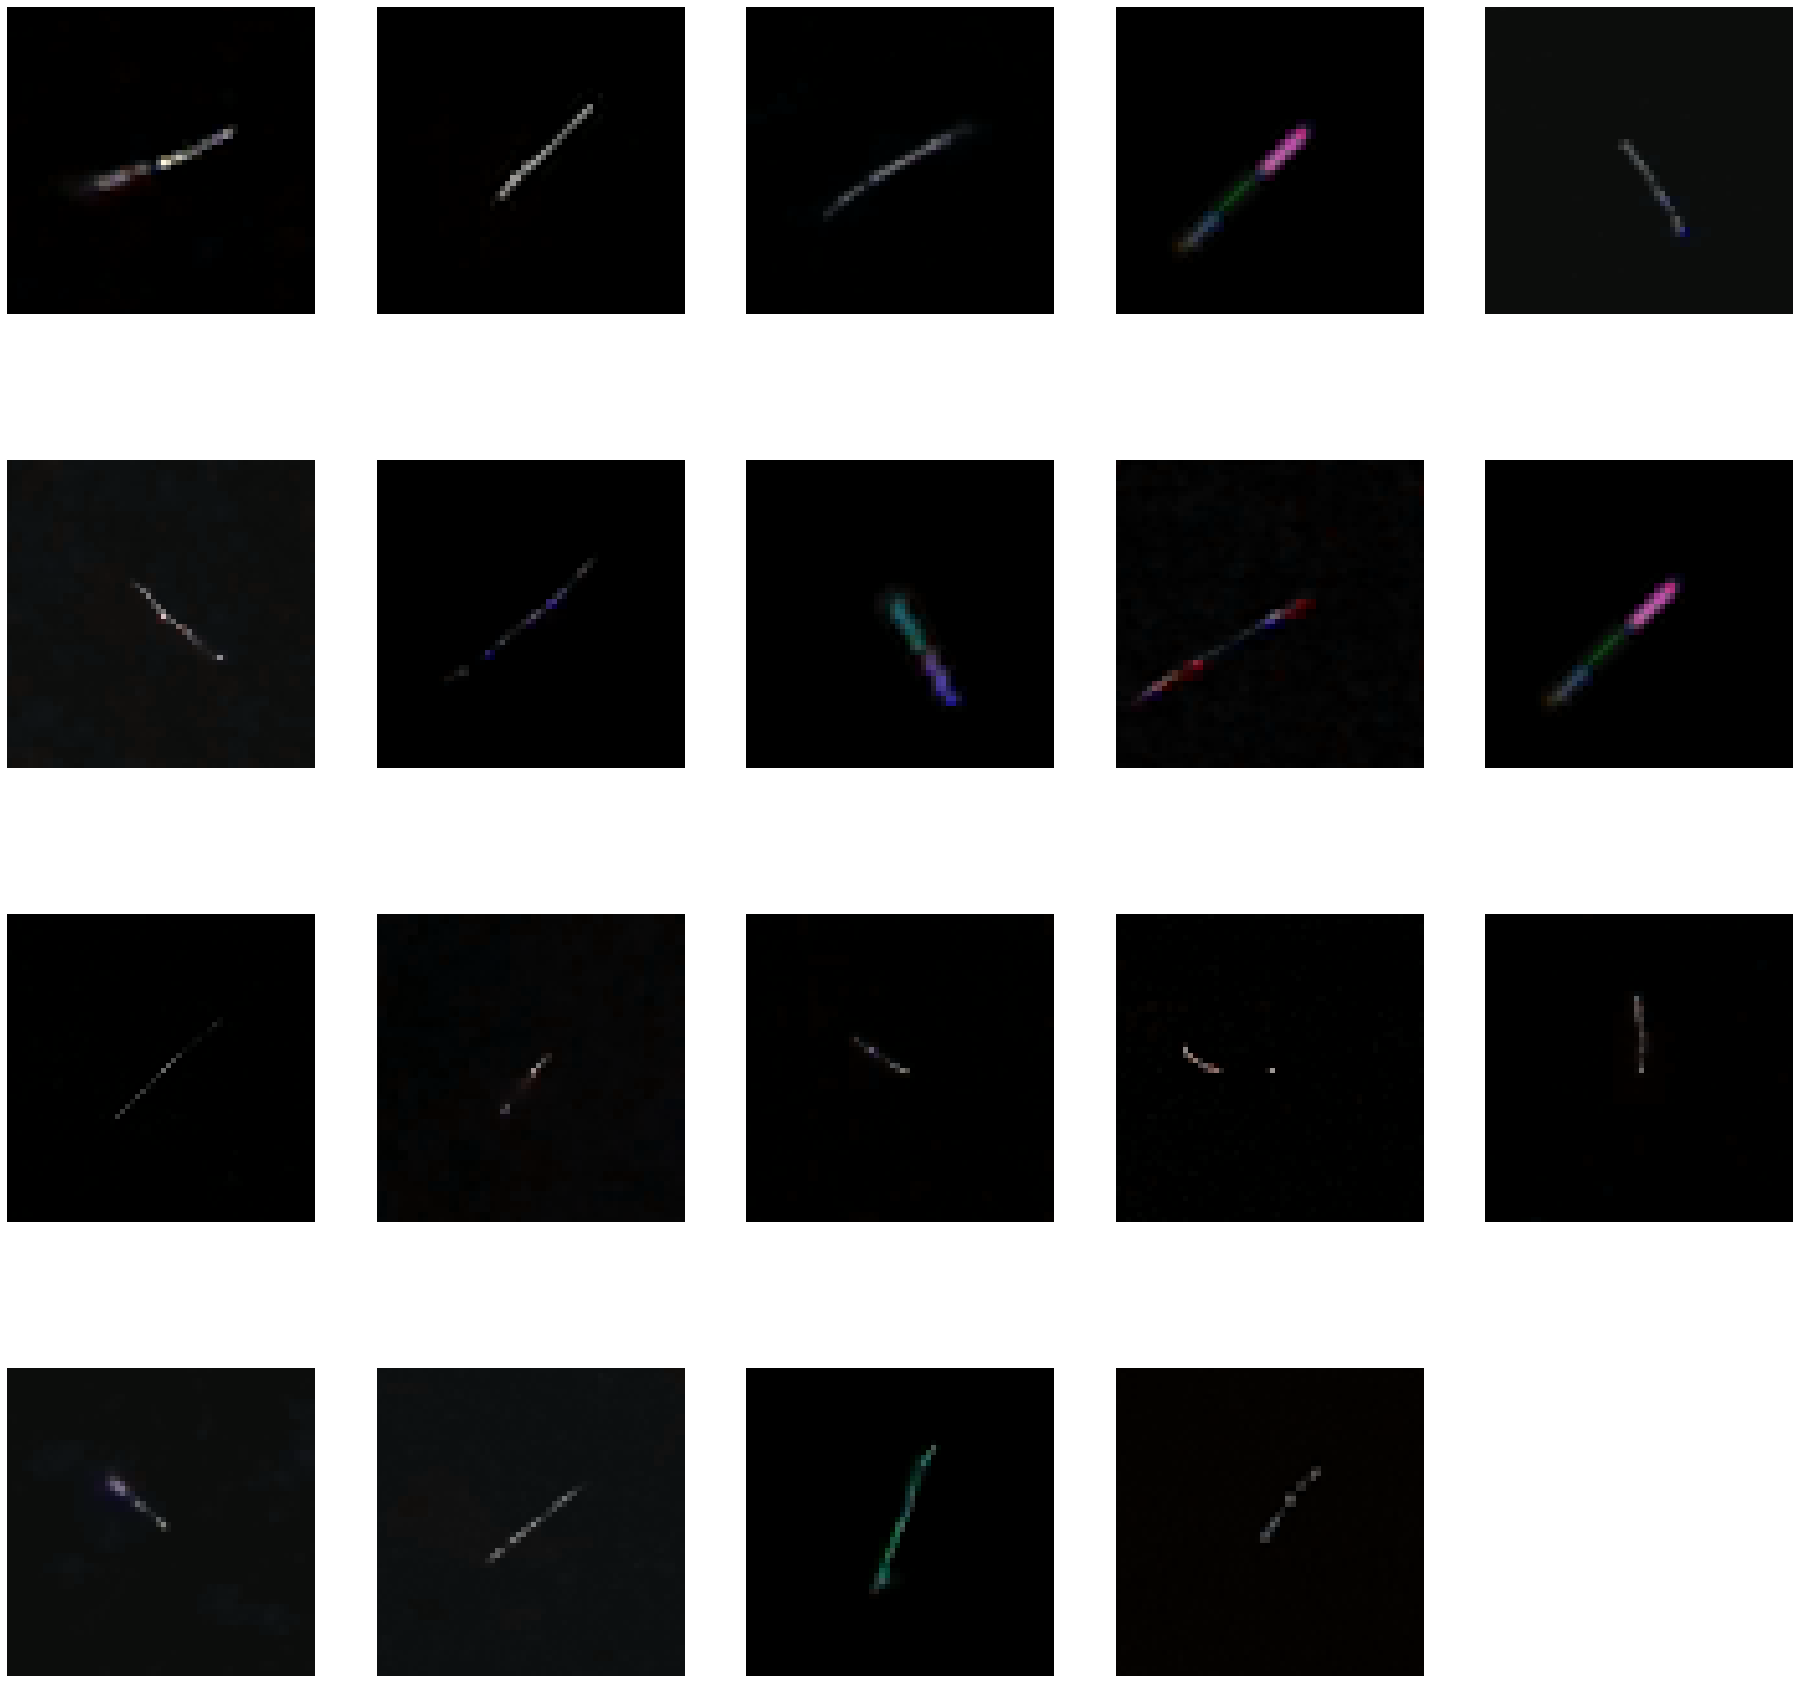

In [12]:
tracks_embedding = encoder_embedding(TRACKS_AC, tracks2_set[tracks2_test])
tracks_t_files = np.asarray(tacks2_files)[tracks2_test]
optics(tracks_embedding, tracks_t_files, 150)

[0 0 0 ... 0 0 0]
[ 560  750  818 1980 1983 2004 2007 2010 2017 2018 2023 2026 2035 2044
 2051 2056 2057 2059 2062 2075 2084 2085 2087 2096 2101 2102 2108 2115
 2116 2117 2132 2134 2152]
33
hit-images-final2/line\22237251.png
hit-images-final2/line\22490031.png
hit-images-final2/line\22237251.png
hit-images-final2/worms\22036223.png
hit-images-final2/worms\22426125.png
hit-images-final2/worms\22398103.png
hit-images-final2/worms\11822754.png
hit-images-final2/worms\22326858.png
hit-images-final2/worms\22206779.png
hit-images-final2/worms\22177539.png
hit-images-final2/worms\22324071.png
hit-images-final2/worms\22323745.png
hit-images-final2/worms\21972249.png
hit-images-final2/worms\22343771.png
hit-images-final2/worms\22007747.png
hit-images-final2/worms\22428527.png
hit-images-final2/worms\13652533.png
hit-images-final2/worms\22343771.png
hit-images-final2/worms\22429725.png
hit-images-final2/worms\22340438.png
hit-images-final2/worms\22449125.png
hit-images-final2/worms\22036548.png

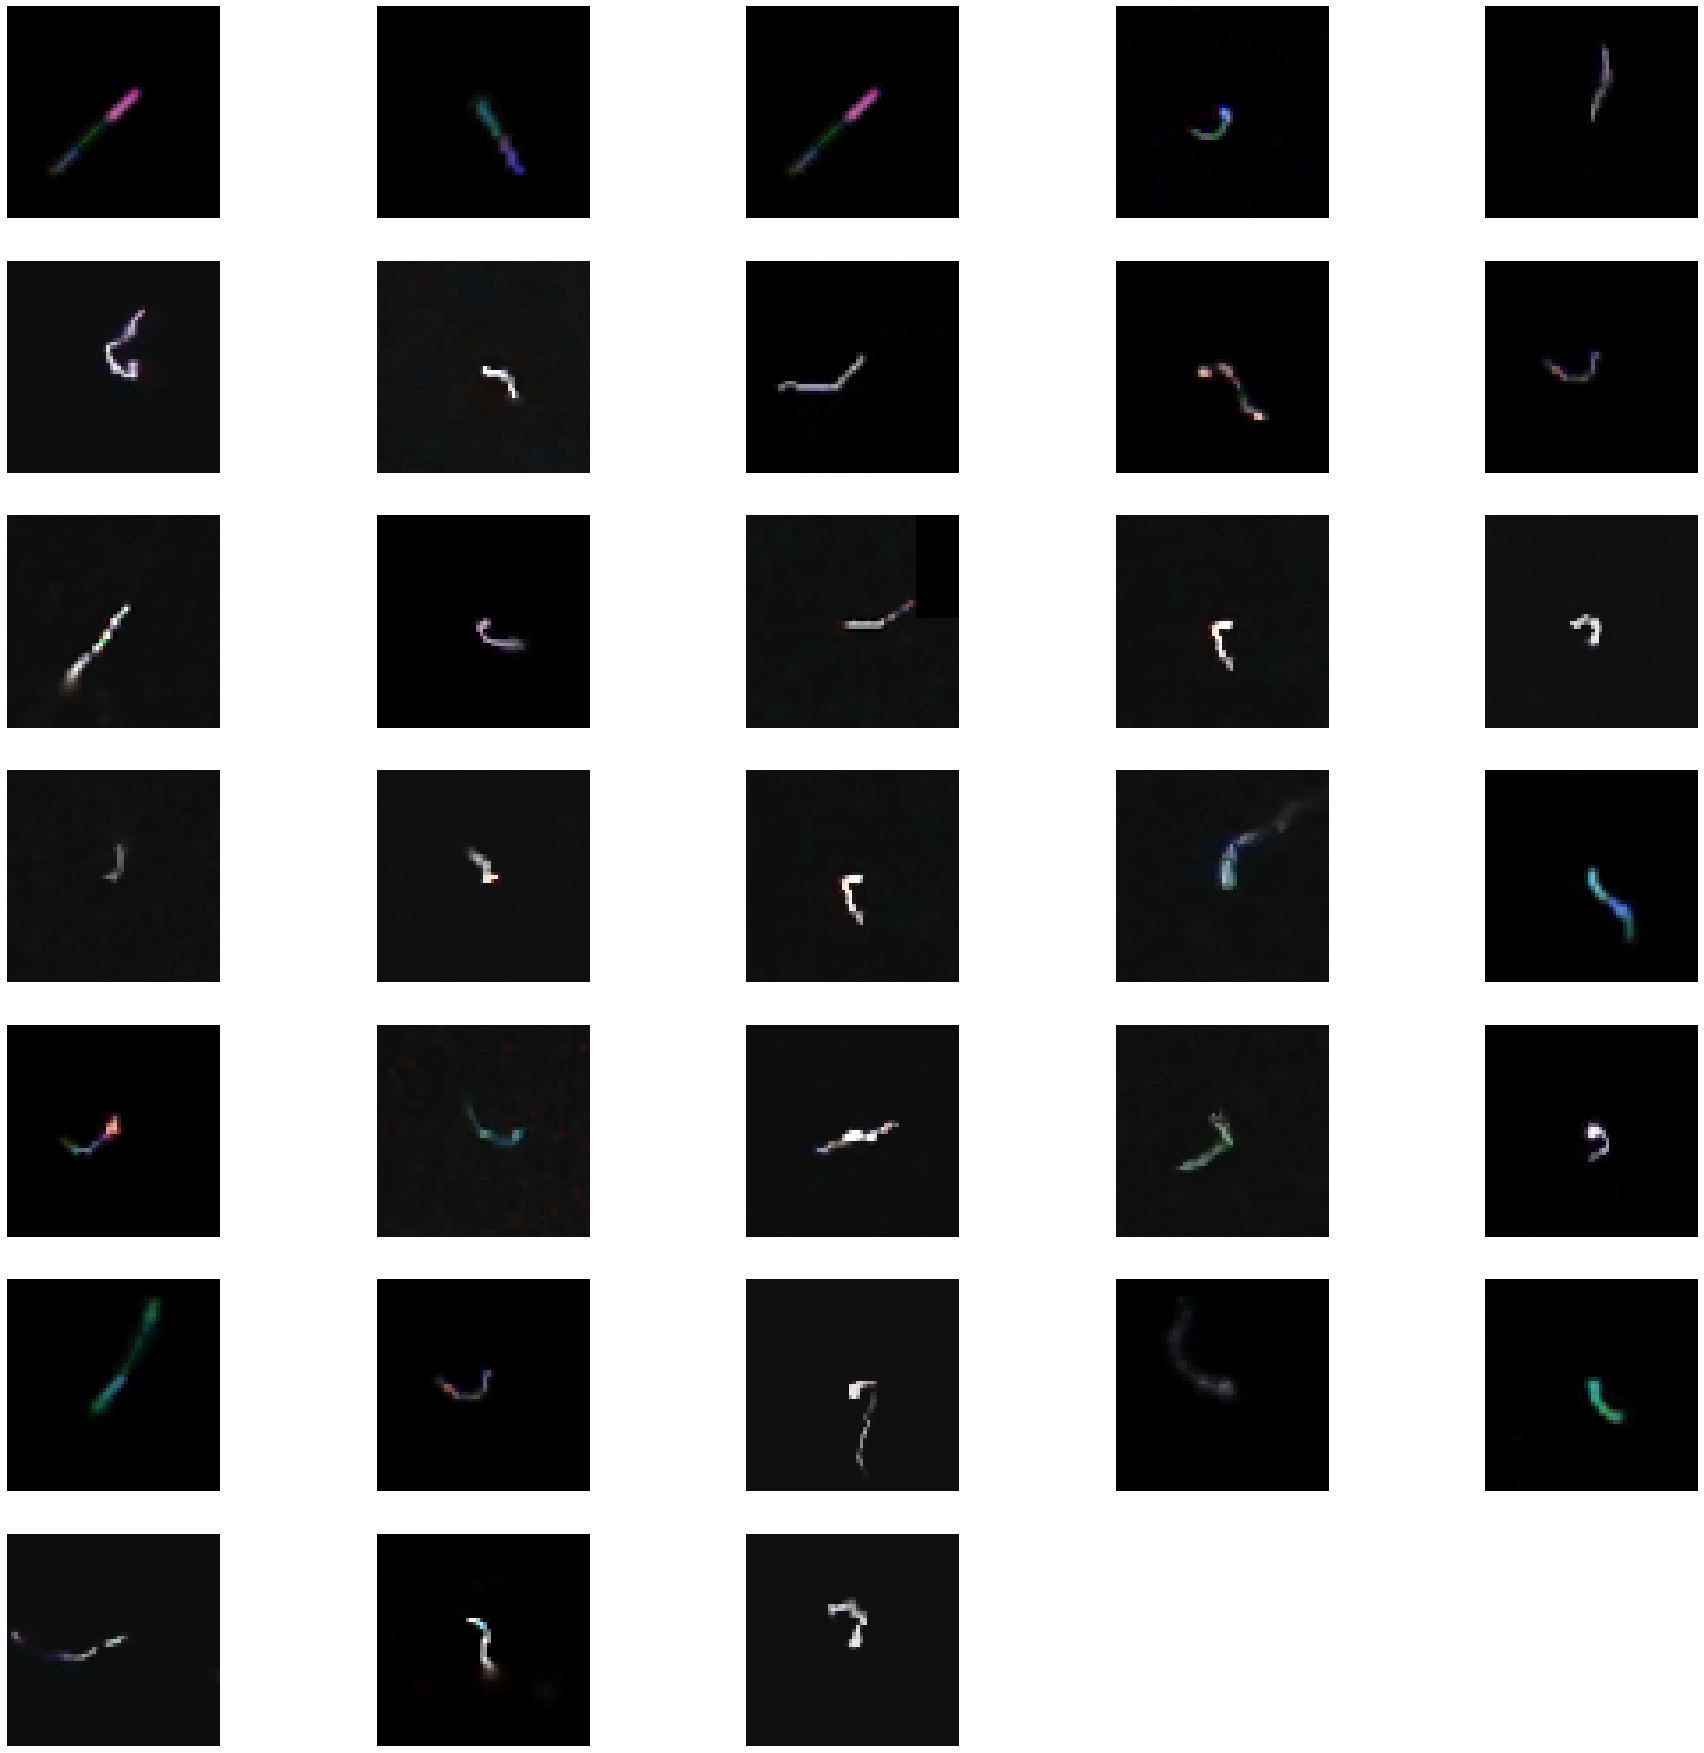

In [13]:
worms_embedding = encoder_embedding(TRACKS_AC, worms2_set[worms2_test])
worms_t_files = np.asarray(worms2_files)[worms2_test]

embedding = np.vstack([tracks_embedding, worms_embedding])
t_files = np.hstack([tracks_t_files, worms_t_files])

optics(embedding, t_files, 175)

[ 0  0  0 ...  0  0 -1]
[  16  207  384  560  568  735  749  750  809  818  854  855  913  945
 1071 1258 1518 1633 1938 1976]
20
hit-images-final2/line\11834173.png
hit-images-final2/line\17223488.png
hit-images-final2/line\23740643.png
hit-images-final2/line\22237251.png
hit-images-final2/line\23048228.png
hit-images-final2/line\22448493.png
hit-images-final2/line\23321006.png
hit-images-final2/line\22490031.png
hit-images-final2/line\23143320.png
hit-images-final2/line\22237251.png
hit-images-final2/line\11854900.png
hit-images-final2/line\23186082.png
hit-images-final2/line\23653785.png
hit-images-final2/line\23447798.png
hit-images-final2/line\22032561.png
hit-images-final2/line\23143241.png
hit-images-final2/line\17886508.png
hit-images-final2/line\14276151.png
hit-images-final2/line\23278286.png
hit-images-final2/me\6044.png


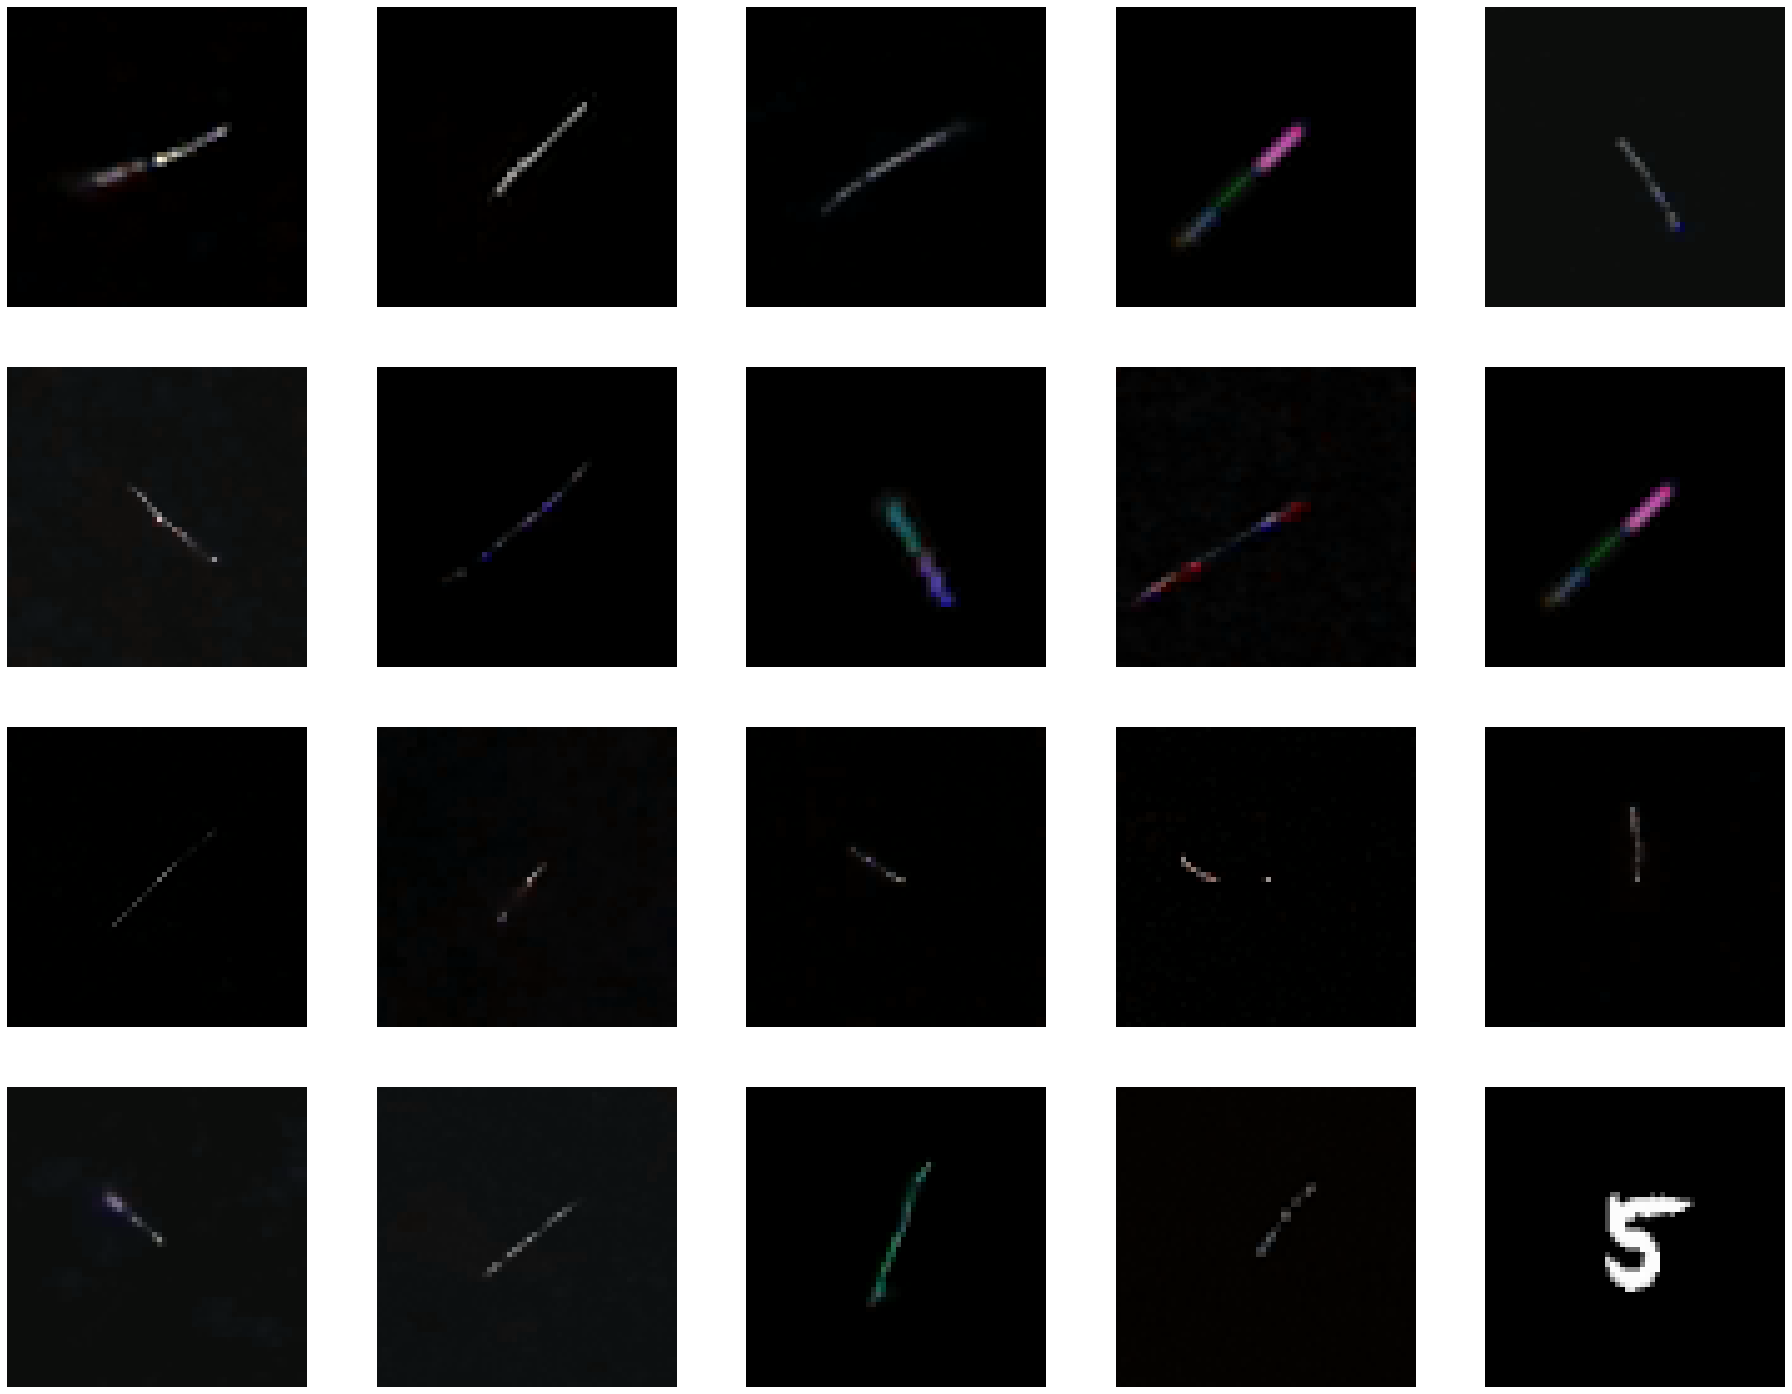

In [17]:
me_set, me_files = load_images('hit-images-final2/me')
me_embedding = encoder_embedding(TRACKS_AC, me_set)
me_files = np.asarray(me_files)

embedding = np.vstack([tracks_embedding, me_embedding])
t_files = np.hstack([tracks_t_files, me_files])

optics(embedding, t_files, 150)

[ 0  0  0 ...  0  0 -1]
[1976]
1
hit-images-final2/me\6044.png


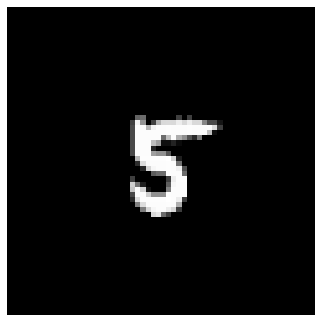

In [22]:
me_set, me_files = load_images('hit-images-final2/me')
me_embedding = encoder_embedding(TRACKS_AC, me_set)
me_files = np.asarray(me_files)

embedding = np.vstack([tracks_embedding, me_embedding])
t_files = np.hstack([tracks_t_files, me_files])

optics(embedding, t_files, 220)